## Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами.

Необходимо спарсить с сайта датасет и обучить на нём модель. Работа состоит из двух частей:

<b><u>Часть 1:</u></b>

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

- сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”);
- сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной;
- блоги - тексты заметок + число просмотров;
- и любые другие ваши идеи, которые подходят под такой формат.
Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.
Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла).

<b><u>Часть 2:</u></b>

- разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования;
- примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена;
- если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической;
- постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик;
- визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.
P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь, главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

In [169]:
import requests 
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Часть 1: Парсим сайт `РИА НОВОСТИ`.

Сначала собираем новостные категории.

In [28]:
page_link = 'https://ria.ru'

response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
soup = BeautifulSoup(response.content, 'html.parser')
sections = soup.findAll('a', attrs={'class':'cell-extension__item-link'})

section_names = []

for i in sections:
    section_names.append(i.attrs['href'])

section_names

['/politics/',
 '/world/',
 '/economy/',
 '/society/',
 '/incidents/',
 '/defense_safety/',
 '/science/',
 'https://rsport.ria.ru/',
 '/culture/',
 '/religion/',
 'https://ria.ru/tourism/',
 '/longread/',
 '/authors/',
 '/photolents/',
 '/video/',
 '/infografika/',
 '/donbass-2014-2022/']

Удаляем категории, которые не подходят для парсинга (мультимедиа контент и имеющие отличную от основных категорий html-разметку).

In [29]:
section_names = section_names[:-4]
for sec in section_names:
    if 'https' in sec:
        section_names.remove(sec)
    else: pass

section_names

['/politics/',
 '/world/',
 '/economy/',
 '/society/',
 '/incidents/',
 '/defense_safety/',
 '/science/',
 '/culture/',
 '/religion/',
 '/longread/',
 '/authors/']

Спарсим основную информацию (название новости, ссылку на нее, дату публикации и кол-во просмотров) о новостях в разных категориях. Саму новость спарсить не получается - парсер "не видит" часть страницы с текстом (тэг `div`, класс `article__text`). Видимо стоит защита от плагиата.

In [30]:
def getData(page_link):

    #___creating empty dataset
    data = pd.DataFrame(columns=['name', 'link', 'date', 'views'])

    #___connecting to the site
    response = requests.get(page_link, time.sleep(5), headers={'User-Agent': UserAgent().chrome})
    if not response.ok:
        return response.status_code

    soup = BeautifulSoup(response.content, 'html.parser')

    #___collecting main information
    objects = soup.findAll('a', attrs={'class':'list-item__title color-font-hover-only'})    
    date = soup.findAll('div', attrs={'class':'list-item__date'})
    views = soup.findAll('div', attrs={'class':'list-item__views-text'})

    #___processing collected information

    for num in range(len(objects)):
        data.loc[num, ['name', 'link', 'date', 'views']] = objects[num].text, objects[num].attrs['href'], date[num].text, views[num].text
                
    return data

In [31]:
data_collected = pd.DataFrame(columns=['name', 'link', 'date', 'views'])

for sec in section_names:
    parsed_data = getData('https://ria.ru' + sec)

    data_collected = data_collected.append(parsed_data, ignore_index=True)

data_collected.head()

,name,link,date,views
0,Совещание правительства по ситуации в Республи...,https://ria.ru/20220815/mishustin-1809606987.html,10:14,22
1,ЕС не хочет расплачиваться за политику США в о...,https://radiosputnik.ria.ru/20220814/ssha-1809...,"Вчера, 20:06",4217
2,"Политолог рассказал, зачем делегация из США мо...",https://radiosputnik.ria.ru/20220814/tayvan-18...,"Вчера, 19:26",1653
3,Москва рассказала США о последствиях признания...,https://radiosputnik.ria.ru/20220814/mid-rf-18...,"Вчера, 16:52",10284
4,Делегация конгрессменов США прибыла на Тайвань,https://radiosputnik.ria.ru/20220814/tayvan-18...,"Вчера, 16:39",3965


## Часть 2: NLP.

Загружаем датасет с отзывами на фильмы с сайта IMDB, т.к. спарсить текст новостей с сайта РИА НОВОСТИ не получилось.

In [32]:
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [34]:
data.duplicated().sum()

418

In [35]:
data.drop_duplicates(inplace=True)

In [36]:
data.sentiment.value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

Датасет сбалансирован по классам. Заменим текстовое название классов числовым обозначением.

In [37]:
data.sentiment.replace(['negative', 'positive'], [0, 1], inplace=True)
data.sentiment.value_counts()

1    24884
0    24698
Name: sentiment, dtype: int64

Удаляем тег `<br />`.

In [38]:
data.review = [re.sub(r'<br />', ' ', text)  for text in data.review]

### 2.1 Разобьем датасет на train/test (80% / 20%)

In [39]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(data.drop(columns='sentiment'), data.sentiment, test_size=0.2, random_state=800)
texts_train.shape, texts_test.shape, y_train.shape, y_test.shape

((39665, 1), (9917, 1), (39665,), (9917,))

In [40]:
texts_train.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes where other sh

### 2.2 Применим TF-IDF преобразование текстового описания

Используем как отдельные токены, так и биграммы.

Отсеим стоп-слова и слова, которые встречаются слишком редко/часто (параметры min_df/max_df).

Также необходимо убрать l2-регуляризацию.

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

# lowercase     - приводит все слова к нижнему регистру (+)
# analyzer      - значения токенов - слова или отдельные символы (слова)
# stop_words    - удаляет стоп-слова (англицкие, +)
# ngram_range   - диапазон размерности н-грамм (монограммы и биграммы)
# max_df        - максимально допустимая встречаемость слов (в 99% наблюдений и более)
# min_df        - минимально допустимая встречаемость слов (в 1% наблюдений и менее)
# max_features  - максимальное количество слов для эмбединга (не ограничено)
# norm          - тип нормализации получаемых векторов (отсутствует)

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1, 2), max_df=0.99, min_df=0.01, max_features=None, norm=None)

In [95]:
x_train = vectorizer.fit_transform(texts_train.review)
x_test = vectorizer.transform(texts_test.review)

In [96]:
x_train.todense()[:1]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

### 2.3...2.4 Обучаем и настраиваем логистическую регрессию

In [97]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

folds = KFold(n_splits=5, shuffle=True, random_state=800)
parameters = {'penalty': ['l2', 'l1', 'none', 'elasticnet'],
              'C': list(np.arange(0.1, 1.1, 0.1))
            }

model = LogisticRegression(random_state=800)

model_grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=folds)

model_grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=800, shuffle=True),
             estimator=LogisticRegression(random_state=800),
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0],
                         'penalty': ['l2', 'l1', 'none', 'elasticnet']},
             scoring='f1')

In [98]:
print('Параметры лучшей модели: {}\n F1-score лучшей модели: {:.3f}'.format(model_grid.best_params_, model_grid.best_score_))

Параметры лучшей модели: {'C': 0.1, 'penalty': 'l2'}
 F1-score лучшей модели: 0.867


In [99]:
model = LogisticRegression(penalty='none', C=0.1, random_state=800)
model.fit(x_train, y_train)
prediction = model.predict(x_test)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4938
           1       0.86      0.87      0.87      4979

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



У модели хорошее качество.

### 2.5 Визуализация получившихся коэффициентов регрессии и интерпретация результатов

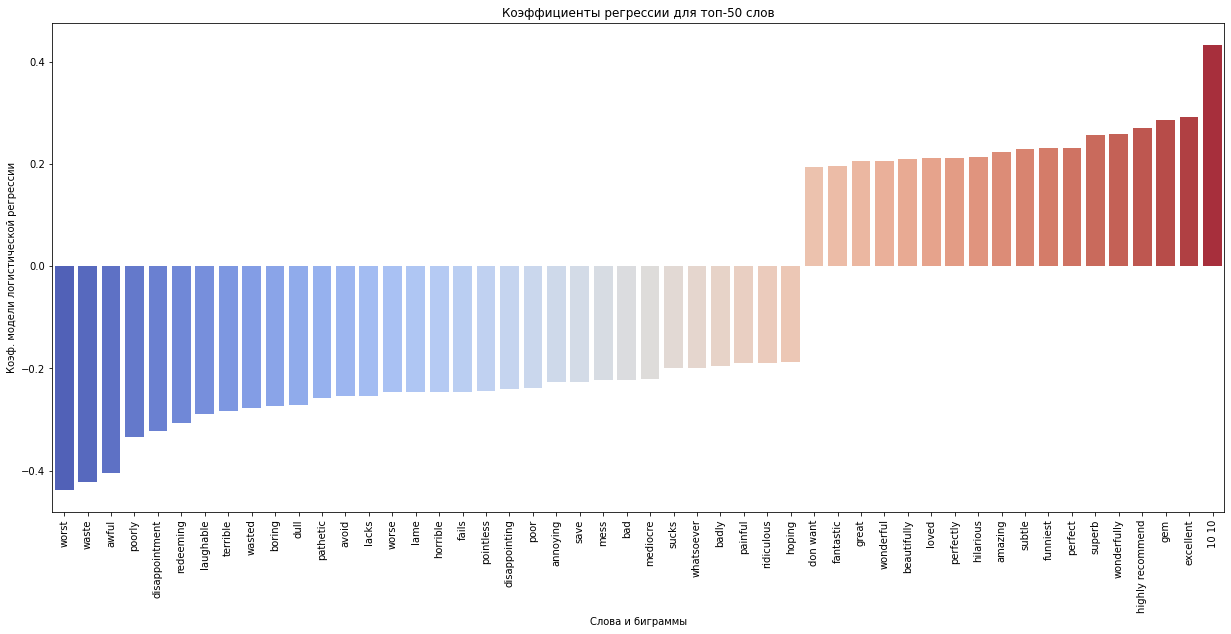

In [173]:
words_importance = pd.DataFrame({'coef': model.coef_.tolist()[0], 'words':vectorizer.get_feature_names()})
words_importance = words_importance.reindex(words_importance.coef.abs().sort_values(ascending=False).index)[:50].sort_values(by='coef')

plt.figure(figsize=(21, 9))
ax = sns.barplot(x=words_importance['words'], y=words_importance['coef'], palette='coolwarm')
ax.set(xlabel='Слова и биграммы', ylabel='Коэф. модели логистической регрессии', title='Коэффициенты регрессии для топ-50 слов')
plt.xticks(rotation=90)
plt.show()

Распределение слов закономерное - для негативных отзывов наибольшие веса у слов `worst, waste, awful, poorly, disappointment`, для позитивных - `10 10, excellent, gem, highly recommend, wonderfully`. В целом главных индикаторов негативных отзывов гораздо больше - 32 против 18.